In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


In [5]:
# Wczytanie zbioru danych oraz zmiana rozmiaru obrazów na 80x80
valid_ds = tf.keras.utils.image_dataset_from_directory('data/Validation', image_size=(80,80))
train_ds = tf.keras.utils.image_dataset_from_directory('data/Training', image_size=(80,80))


Found 10000 files belonging to 2 classes.
Found 44000 files belonging to 2 classes.


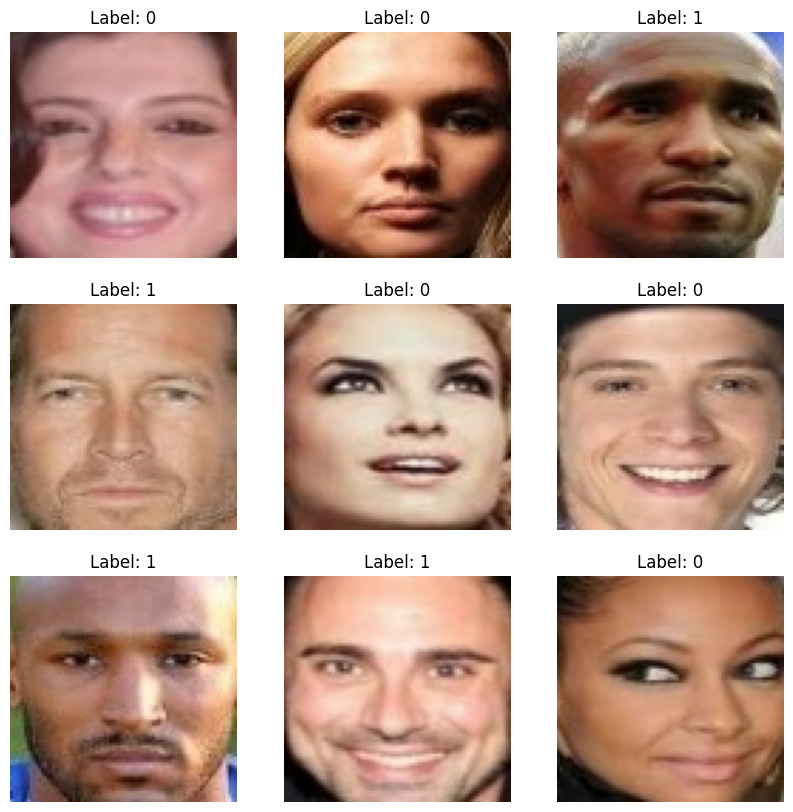

In [6]:
import matplotlib.pyplot as plt

# Przykładowe obrazy z zestawu danych
for images, labels in train_ds.take(1):
    # Wyświetl przykładowe obrazy
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Label: {}'.format(labels[i]))
        plt.axis("off")
    plt.show()

In [43]:
# Normalizacja obrazów do wartości z przedziału [0,1]
valid_ds = valid_ds.map(lambda x,y: (x/255, y))
train_ds = train_ds.map(lambda x,y: (x/255, y))

In [10]:
# Rotacja obrazu o 5 stopni by zwiększyć zróżnicowanie danych
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.05),
])

In [155]:
# Zdefiniowanie modelu sieci neuronowej
random.seed(0)

model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80,80, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 78, 78, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,081 (4.36 MB)

 Trainable params: 1,142,081 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Skompilowanie modelu z wykorzystaniem optymalizatora Adam oraz funkcji straty BinaryCrossentropy
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])

In [13]:
# dodanie wczesniejsze zakonczenie programu wtedy gdy model przestanie się uczyć

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Liczba epok bez poprawy po której trening zostanie przerwany
    verbose=1,
    restore_best_weights=True  # Przywróć najlepsze wagi po zakończeniu
)

In [14]:
# dodałem blok niżej możliwość odczytania modelu by nie trzeba było powtarzać uczenia modelu.
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  callbacks=[early_stopping],
  verbose=1
)

Epoch 1/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 326s 236ms/step - accuracy: 0.7652 - loss: 0.4697 - val_accuracy: 0.9183 - val_loss: 0.2186
Epoch 2/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 107s 78ms/step - accuracy: 0.9186 - loss: 0.2182 - val_accuracy: 0.9421 - val_loss: 0.1559
Epoch 3/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 106s 77ms/step - accuracy: 0.9323 - loss: 0.1817 - val_accuracy: 0.9499 - val_loss: 0.1362
Epoch 4/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 96s 70ms/step - accuracy: 0.9411 - loss: 0.1651 - val_accuracy: 0.9515 - val_loss: 0.1346
Epoch 5/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 107s 78ms/step - accuracy: 0.9445 - loss: 0.1521 - val_accuracy: 0.9573 - val_loss: 0.1174
Epoch 6/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 124s 90ms/step - accuracy: 0.9504 - loss: 0.1384 - val_accuracy: 0.9518 - val_loss: 0.1337
Epoch 7/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 104s 75ms/step - accuracy: 0.9502 - loss: 0.1350 - val_accuracy: 0.9562 - val_loss: 0.1197
Epoch 8/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 107s 78ms/step - accuracy: 

In [26]:
# model.save('saved_model.keras')



In [9]:
model = load_model('saved_model.keras')

In [10]:
# Wczytanie zbioru danych testowych oraz zmiana rozmiaru obrazów na 80x80
test_ds = tf.keras.utils.image_dataset_from_directory('data/Test', image_size=(80,80))

Found 4658 files belonging to 2 classes.


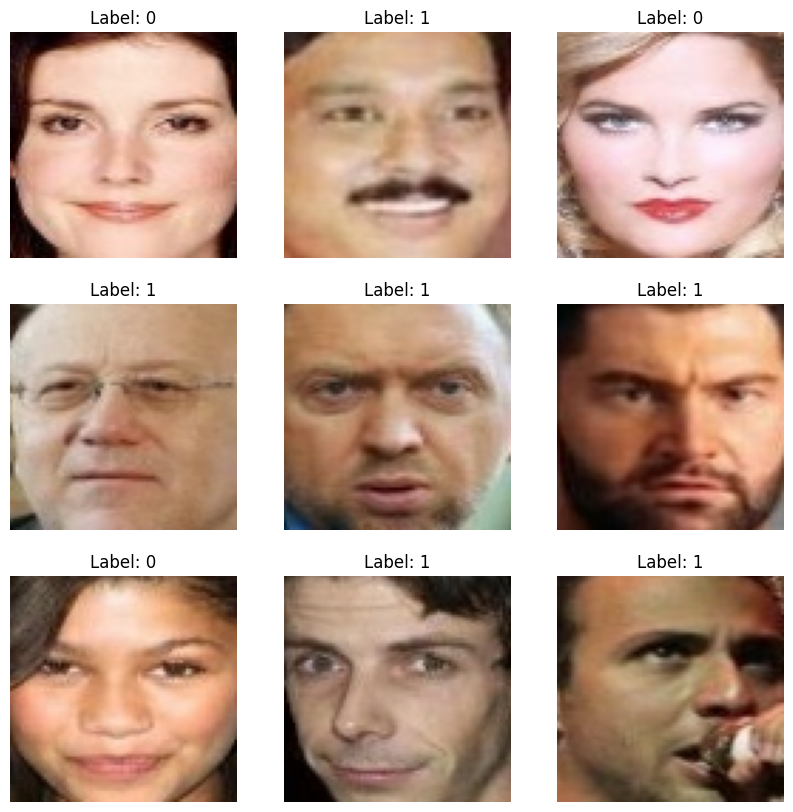

In [11]:
# przykładowe obrazy z zestawu danych testowych
for images, labels in test_ds.take(1):
    # Wyświetl przykładowe obrazy
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Label: {}'.format(labels[i]))
        plt.axis("off")
    plt.show()

In [12]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision = Precision()
acc = BinaryAccuracy()
recall = Recall()

In [13]:
# Normalizacja obrazów do wartości z przedziału [0,1]
test_ds = test_ds.map(lambda x,y: (x/255, y))

In [22]:
# tablica z błednie ocenionymi zdjeciami
false_img = []

In [23]:
for batch in test_ds:
    x, y = batch
    yhat = model.predict(x)
    yhat_binary = [1 if prediction[0] >= 0.5 else 0 for prediction in yhat]
    for i, b in enumerate(yhat_binary):
        if(b != y[i]):
            # dodanie do tablicy zdjecia i zmiana na format rgb
            false_img.append((x[i]*255, y[i]))

    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    acc.update_state(y, yhat)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [24]:
print(f"Precision:{precision.result().numpy()},Recall: {recall.result().numpy()},Accuracy: {acc.result().numpy()}")

Precision:0.9672259092330933,Recall: 0.9630924463272095,Accuracy: 0.9615715146064758


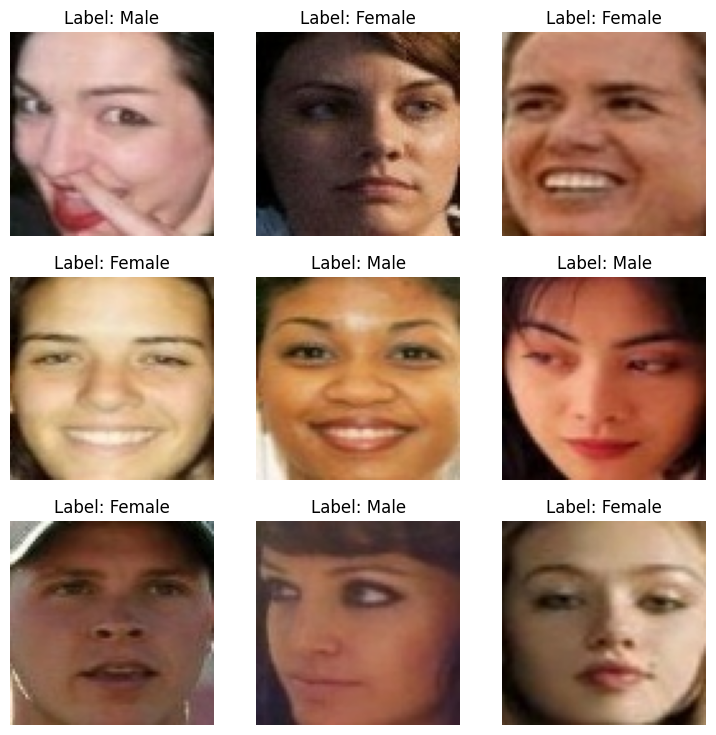

In [32]:
# Wyswietlenie 9 pierwszych rekordów z tablicy błednie ocenionych zdjęć
# label który jest wyświetlany jest to przypisana odpowiedź dla danego zdjęcia
plt.figure(figsize=(9, 9))

for i, image in enumerate(false_img[:9]):
    image_tensor = tf.cast(image[0], tf.uint8)
    ax = plt.subplot(3, 3, i+1)
    plt.title('Label: {}'.format("Male" if image[1] == 1 else "Female"))
    plt.imshow(image_tensor.numpy())
    
    plt.axis("off")
plt.show()


In [30]:
# Test na losowym zdjeciu z pixabay.com
import cv2

In [95]:
man = cv2.imread('man-face-test.jpg')
man = cv2.cvtColor(man, cv2.COLOR_BGR2RGB)

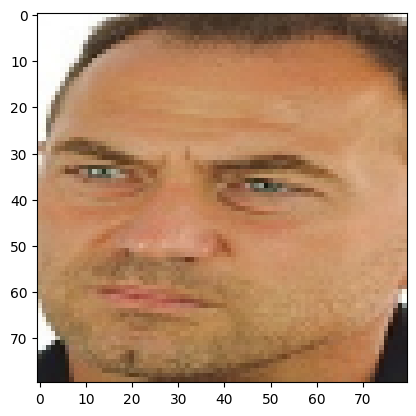

In [96]:
resize = tf.image.resize(man, (80,80))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [97]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [94]:
yhat

array([[0.9993579]], dtype=float32)

In [151]:
woman = cv2.imread('woman-face-test.jpg')
woman = cv2.cvtColor(woman, cv2.COLOR_BGR2RGB)

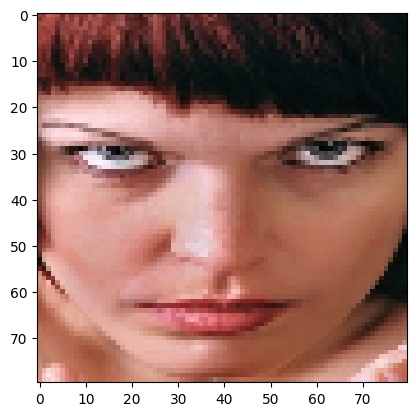

In [152]:
resize = tf.image.resize(woman, (80,80))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [153]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [154]:
yhat

array([[0.01851378]], dtype=float32)